In [1]:
import os.path as osp
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.utils import k_hop_subgraph, from_networkx
import pickle
import networkx as nx
from math import floor
from tqdm import tqdm
import seaborn as sns
from scipy.sparse import coo_matrix,csr_matrix

import sys
sys.path.append("..")

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

prefix = '/gpfs_home/spate116/singhlab/GCN_Integration/scripts/BI/pyro_model/synthetic/'
G = nx.read_gpickle( prefix + 'data/syn3_G.pickle')
with open(prefix + 'data/syn3_lab.pickle', 'rb') as f:
    labels = pickle.load(f)

x = torch.tensor([x[1]['feat'] for x in G.nodes(data=True)])
edge_index = torch.tensor([x for x in G.edges])
edge_index_flipped = edge_index[:, [1, 0]]
edge_index = torch.cat((edge_index, edge_index_flipped))
y = torch.tensor(labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index.T, y=y)

class Net(torch.nn.Module):
    def __init__(self, x=64):
        super(Net, self).__init__()
        self.conv1 = GCNConv(10, x)
        self.conv2 = GCNConv(x, x)
        self.conv3 = GCNConv(x, x)
        self.fc = torch.nn.Linear(x, max(y).tolist()+1)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        return self.fc(x)
    
# Load everything onto the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
x, edge_index = data.x, data.edge_index

model = Net(x=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_loss = 100
pbar = tqdm(range(10000))
for epoch in pbar:
    # Training step
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.cross_entropy(log_logits, data.y)
    loss.backward()
    optimizer.step()

    # Testing step
    model.eval()
    best_loss = loss if loss < best_loss else best_loss
    pbar.set_description("Acc -> %.4f" % torch.mean((torch.argmax(log_logits, dim=1) == data.y).float()).item())

Acc -> 0.9403: 100%|██████████| 10000/10000 [00:48<00:00, 207.50it/s]


Explain node 549: 100%|██████████| 1000/1000 [00:05<00:00, 196.68it/s]


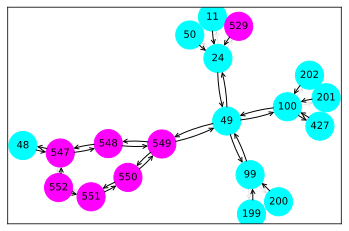

In [2]:
explainer = GNNExplainer(model, epochs=1000)
node_idx = 549
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

Loss -> 0.0000: 100%|██████████| 3000/3000 [03:07<00:00, 16.02it/s]


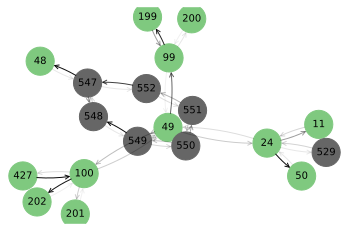

In [60]:
from BayesianExplainerNF import BayesianExplainer

k = 3
sharp = 1e-12
splines = 6
explainer = BayesianExplainer(model, node_idx, k, x, edge_index, sharp, splines)
avgs = explainer.train(epochs=3000, lr=5, lambd=5e-11, window=500, p = 1.1, log=True)

edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, data.y, k)
plt.show()

In [8]:
subset, edge_index_adj, mapping, edge_mask_hard = k_hop_subgraph(
            node_idx, 3, edge_index, relabel_nodes=True)
x_adj = x[subset]

In [9]:
edge_index_adj.shape

torch.Size([2, 38])

In [61]:
import numpy as np

model = model.to(device)
full_cat = model(x_adj, edge_index_adj)[mapping].reshape(-1)
full_cat = full_cat.detach().cpu().numpy()
full_cat = np.exp(full_cat) / np.exp(full_cat).sum()
full_cat

array([0.9218152 , 0.07818482], dtype=float32)

In [79]:
N = 20000

masks = 0.7 * torch.ones([
    N, edge_index_adj.shape[1]
])

masks = torch.bernoulli(masks)
masks

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [80]:
import numpy as np
from math import log
from tqdm import tqdm

masks_np = masks.cpu().numpy()
log_losses = []

for i in tqdm(range(N)):
    mean = model(x_adj, edge_index_adj[:, masks[i, :] == 1])[mapping].reshape(-1).detach().cpu().numpy()
    mean = np.exp(mean) / np.exp(mean).sum()
    log_losses.append(-mean[0] * log(full_cat[0]) + mean[1] * log(full_cat[1]))

100%|██████████| 20000/20000 [00:50<00:00, 395.00it/s]


In [81]:
log_losses = np.array(log_losses)
masks_np

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [82]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(masks_np, log_losses)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
imp = np.abs(reg.coef_)
norm_imp = imp / imp.sum()

In [84]:
norm_imp

array([1.28033189e-02, 5.17171249e-02, 8.17559101e-03, 1.01456754e-02,
       2.58720964e-02, 8.16407520e-03, 4.49926732e-03, 3.23152453e-01,
       1.32554574e-02, 1.45973945e-02, 9.62651987e-03, 6.66265236e-03,
       8.97664297e-03, 3.31230350e-02, 4.14205566e-02, 6.31210059e-02,
       9.32362489e-03, 3.55366319e-02, 4.06731851e-02, 9.70245525e-03,
       5.56479720e-03, 6.77375635e-03, 7.64635811e-03, 2.74338610e-02,
       3.13055515e-02, 4.83467281e-02, 1.00328517e-03, 2.63127545e-03,
       7.62990676e-03, 1.05084395e-02, 1.04542170e-02, 1.08564775e-02,
       7.89468642e-03, 2.51386751e-04, 2.08569970e-02, 3.41495089e-02,
       3.80203361e-03, 3.23419645e-02], dtype=float32)

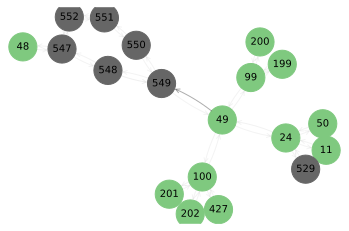

In [85]:
explainer.visualize_subgraph(node_idx, edge_index, norm_imp, data.y, k)
plt.show()

In [86]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor()
reg.fit(masks_np, log_losses)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [98]:
imp = reg.feature_importances_
norm_imp = imp / imp.sum()

In [99]:
norm_imp

array([0.        , 0.06940389, 0.        , 0.        , 0.00346509,
       0.        , 0.        , 0.58863963, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02814356, 0.01717401,
       0.06224793, 0.        , 0.01765876, 0.01448965, 0.        ,
       0.        , 0.        , 0.        , 0.00498924, 0.0558082 ,
       0.06074234, 0.0058764 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00641371,
       0.02810535, 0.01670531, 0.02013691])

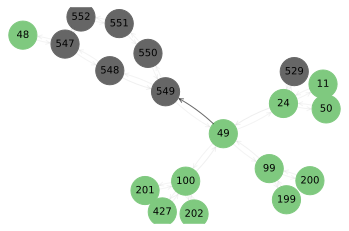

In [100]:
explainer.visualize_subgraph(node_idx, edge_index, norm_imp, data.y, k)
plt.show()